# Import

In [321]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

import numpy as np

# DataLoader

In [322]:
path = './datasets/'

transform = transforms.Compose([transforms.ToTensor()])

train_data = CIFAR100(root=path,train=True,transform=transform,download=True)
test_data = CIFAR100(root=path,train=False,transform=transform,download=True)

batch_size = 100

train_loader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=0)
test_loader = DataLoader(dataset=test_data,batch_size=batch_size,shuffle=False,num_workers=0)

input_shape = train_data[0][0].shape
output_shape = len(train_data.classes)
print()

In [323]:
print(input_shape)
print(output_shape)

torch.Size([3, 32, 32])
100


In [324]:
d_model = 10
max_len = 5

pos_enc = torch.zeros(max_len,d_model,requires_grad=False)
pos = torch.arange(0, max_len, 1, requires_grad=False).reshape(-1,1) 
w_vector = 10000**(-2*(torch.arange(0, (d_model // 2), 1))/d_model)

pos_enc[:,0::2] = torch.cos(pos * w_vector)
pos_enc[:,1::2] = torch.sin(pos * w_vector)

pos_enc

tensor([[ 1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 5.4030e-01,  8.4147e-01,  9.8747e-01,  1.5783e-01,  9.9968e-01,
          2.5116e-02,  9.9999e-01,  3.9811e-03,  1.0000e+00,  6.3096e-04],
        [-4.1615e-01,  9.0930e-01,  9.5018e-01,  3.1170e-01,  9.9874e-01,
          5.0217e-02,  9.9997e-01,  7.9621e-03,  1.0000e+00,  1.2619e-03],
        [-9.8999e-01,  1.4112e-01,  8.8908e-01,  4.5775e-01,  9.9716e-01,
          7.5285e-02,  9.9993e-01,  1.1943e-02,  1.0000e+00,  1.8929e-03],
        [-6.5364e-01, -7.5680e-01,  8.0569e-01,  5.9234e-01,  9.9496e-01,
          1.0031e-01,  9.9987e-01,  1.5924e-02,  1.0000e+00,  2.5238e-03]])

In [325]:
(pos * w_vector / w_vector).size(0)

5

## PositionalEncoding

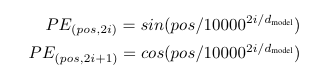

In [326]:
class PositionalEncoding(nn.Module):
# refer to Section 3.5 in the paper

    def __init__(self, device, max_len=512, d_model=16):
        super().__init__()
        self.pos_enc = torch.zeros(max_len,d_model,requires_grad=False, device=device)
        pos = torch.arange(0, max_len, 1, requires_grad=False, device=device).reshape(-1,1) 
        w_vector = 10000**(-2*(torch.arange(0, (d_model // 2), 1, device=device))/d_model)

        self.pos_enc[:,0::2] = torch.cos(pos * w_vector)
        self.pos_enc[:,1::2] = torch.sin(pos * w_vector)


    def forward(self, x):
        """
        x.shape = [batch_size, seq_len, data_dim]
        """
        return x + self.pos_enc[:x.shape[1], :].unsqueeze(0)

## ScaledDotProductAttention

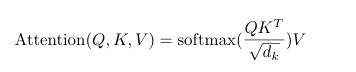

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self,d_model=16):
        super().__init__()
        self.d_model = d_model

    def forward(self, q, k, v, mask=None):
        # fill out here
        # compute attention value based on transformed query, key, value where mask is given conditionally
        """
        q, k, v = transformed query, key, value
        q.shape, k.shape, v.shpae = [batch_size, num_head, seq_len, d_ff=d_model/num_head]
        mask = masking matrix, if the index has value False, kill the value; else, leave the value
        """
        k_T = k.transpose(-1,-2)

        # 1. matmul Q @ K_T
        scores = (q @ k_T) / torch.sqrt(torch.tensor(q.shape[-1]))

        # ( Optional ) masking 
        if mask is not None:
            scores = scores.masked_fill(~mask, float('-inf'))

        # 2. softmax
        attention_weight = F.softmax(scores, dim=-1)

        # 3. matmul attention_weight @ V
        attention_value = attention_weight @ v

        return attention_value

## MultiHeadAttention

In [328]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_model=16,num_head=4):
        super().__init__()
        assert d_model % num_head == 0, "check if d_model is divisible by num_head"

        # params
        self.d_model = d_model
        self.num_head = num_head
        self.d_ff = d_model//num_head

        # q, k, v's weight 
        self.q_weight = nn.Linear(d_model, d_model)
        self.k_weight = nn.Linear(d_model, d_model)  
        self.v_weight = nn.Linear(d_model, d_model)

        # output weight for concat 
        self.output_weight =  nn.Linear(d_model, d_model)  

        # set attention block 
        self.attention = ScaledDotProductAttention(d_model=d_model)

    def forward(self, q, k, v, mask=None):
        # fill out here
        # compute multi-head attention value
        # here, query, key, value are pre-transformed, so you need to transfrom them in this module
        """
        q, k, v = pre-transformed query, key, value
        q.shape, k.shape, v.shpae = [batch_size, seq_len, d_model]
        mask = masking matrix, if the index has value False, kill the value; else, leave the value
        """
        batch_size, seq_len, d_model = q.shape

        # make them learnable 
        q, k, v = self.q_weight(q), self.k_weight(k), self.v_weight(v)

        # reshape [batch_size, seq_len, d_model] to [batch_size, num_head, seq_len, d_ff]
        def reshape(x):
            return x.view(batch_size, seq_len, self.num_head, self.d_ff).transpose(1,2)
        
        q, k, v = reshape(q), reshape(k), reshape(v)

        # calculate attention value 
        attention_value = self.attention(q,k,v,mask=mask)
        
        # concat heads --> result :  [batch_size, seq_len, d_model]
        concated_value = attention_value.transpose(1,2).reshape(batch_size, seq_len, d_model)

        output = self.output_weight(concated_value)

        return output

## PositionwiseFeedForwardNetwork

In [329]:
class PositionwiseFeedForwardNetwork(nn.Module):
    def __init__(self,d_model=16,d_ff=32):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Masking

In [ ]:
class Masking(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self,x):
        # x.shape = (batch_size, seq_len, data_dim)
        batch_size, seq_len, _ = x.shape
        mask = torch.tril(torch.ones(seq_len, seq_len, dtype=torch.bool, device=self.device))
        mask = mask.unsqueeze(0).unsqueeze(0)

        return mask

## LayerNormalization

> [논문](https://arxiv.org/pdf/1607.06450) 읽어서 보충하기 

https://paperswithcode.com/method/layer-normalization

In [331]:
class LayerNormalization(nn.Module):
    def __init__(self,d_model=16,eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self,x):
        mean = x.mean(-1, keepdim=True) 
        var = x.var(-1, unbiased=False, keepdim=True) 

        normed = (x - mean)/torch.sqrt(var + self.eps) # 정규화
        normed = self.gamma * normed + self.beta # 파라미터 추가 

        return normed

## EncoderLayer

In [332]:
class EncoderLayer(nn.Module):
    def __init__(self,d_model=16,num_head=4,d_ff=32,drop_prob=.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_head)
        self.norm1 = LayerNormalization(d_model)

        self.ffn = PositionwiseFeedForwardNetwork(d_model, d_ff)
        self.norm2 = LayerNormalization(d_model)

        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self,enc):
        # multi head attention
        _x = enc
        x = self.attention(q=enc, k=enc, v=enc)

        # add and norm
        x = self.dropout(x)
        x = self.norm1(x + _x)

        # feed forward
        _x = x
        x = self.ffn(x)

        # add and norm
        x = self.dropout(x)
        output = self.norm2(x + _x)

        return output

## DecoderLayer

In [333]:
class DecoderLayer(nn.Module):
    def __init__(self,d_model=16,num_head=4,d_ff=32,drop_prob=.1):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model, num_head)
        self.norm1 = LayerNormalization(d_model)

        self.enc_dec_attention = MultiHeadAttention(d_model, num_head)
        self.norm2 = LayerNormalization(d_model)

        self.ffn = PositionwiseFeedForwardNetwork(d_model, d_ff)
        self.norm3 = LayerNormalization(d_model)

        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self,enc_output,dec,dec_mask):
        # multi head attention
        _x = dec
        x = self.self_attention(q=dec, k=dec, v=dec, mask=dec_mask)

        # add and norm
        x = self.dropout(x)
        x = self.norm1(x + _x)

        # enc - dec attention
        if enc_output is not None:
            _x = x
            x = self.enc_dec_attention(q=x, k=enc_output, v=enc_output)

            # add and norm
            x = self.dropout(x)
            x = self.norm2(x + _x)

        # feed forward
        _x = x
        x = self.ffn(x)

        # add and norm
        x = self.dropout(x)
        output = self.norm3(x + _x)

        return output

## Encoder

In [334]:
class Encoder(nn.Module):
# refer to Section 3.1 and Figure 1 in the paper
# this is a whole encoder, i.e., the left side of Figure 1, consists of the following as well
# input embedding, positional encoding
    """
    in this homework, encoder inputs are not tokens, it is already embeddings in the input dimension
    hence, you don't have to set input embedding layer
    instead, you have to transform the input into the hidden dimension with single linear transformation
    """
    def __init__(self,device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=32,drop_prob=.1):
        super().__init__()
        self.positional_emb = PositionalEncoding(device=device,
                                                 max_len=max_len,
                                                 d_model=d_model)

        self.layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                                  num_head=num_head,
                                                  d_ff=d_ff,
                                                  drop_prob=drop_prob)
                                                  for _ in range(num_layer)])
        
        self.input_fc = nn.Linear(input_dim, d_model)


    def forward(self,x):
        # transform dimension : embedding이 없어서 필요한 부분
        x = self.input_fc(x)

        x = self.positional_emb(x) 

        for layer in self.layers:
            hidden = layer(x)

        return hidden

## Decoder

In [ ]:
class Decoder(nn.Module):
# refer to Section 3.1 and Figure 1 in the paper
# this is a whole decoder, i.e., the left side of Figure 1, consists of the following as well
# input embedding, positional encoding, linear classifier
    """
    in this homework, decoder inputs are not tokens, it is already embeddings in the input dimension
    hence, you don't have to set input embedding layer
    instead, you have to transform the input into the hidden dimension with single linear transformation
    """
    def __init__(self,device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=32,drop_prob=.1):
        super().__init__()
        self.positional_emb = PositionalEncoding(device=device,
                                                 max_len=max_len,
                                                 d_model=d_model)

        self.layers = nn.ModuleList([DecoderLayer(d_model=d_model,
                                                  num_head=num_head,
                                                  d_ff=d_ff,
                                                  drop_prob=drop_prob)
                                     for _ in range(num_layer)])
        
        self.input_fc = nn.Linear(input_dim, d_model)
        self.output_fc = nn.Linear(d_model, input_dim)

    def forward(self,enc_output,y,y_mask):

        y = self.input_fc(y)           # (B, 1024, d_model)
        y = self.positional_emb(y)

        # y_mask shape should be (B, seq_len, seq_len) or (1, seq_len, seq_len)
        for layer in self.layers:
            y = layer(enc_output=enc_output, dec=y, dec_mask=y_mask)

        output = self.output_fc(y)          # (B, 1024, 3)
        # output = y.view(batch_size, c, h, h)  # (B, 3, 32, 32)
        return output

## Transformer

In [ ]:
class Transformer(nn.Module):

    def __init__(self,device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=32,drop_prob=.1):
        super().__init__()
        self.encoder = Encoder(device=device,
                               input_dim=input_dim,
                               num_layer=num_layer,
                               max_len=max_len,
                               d_model=d_model,
                               num_head=num_head,
                               d_ff=d_ff,
                               drop_prob=drop_prob)

        self.decoder = Decoder(device=device,
                               input_dim=input_dim,
                               num_layer=num_layer,
                               max_len=max_len,
                               d_model=d_model,
                               num_head=num_head,
                               d_ff=d_ff,
                               drop_prob=drop_prob)

        self.masking = Masking(device=device)

    def forward(self,x,y):
        # mask
        mask = self.masking(y)

        # encoder
        enc_output = self.encoder(x)

        # decoder
        dec_output = self.decoder(enc_output,y,mask)

        # softmax
        # dec_output = F.softmax(dec_output, dim=-1)
        # loss = nn.BCEWithLogitsLoss(reduction='sum')가 이거라서 주석 처리 
        return dec_output

## ScheduledOptimizer

In [ ]:
class ScheduledOptimizer:
    def __init__(self,optimizer,d_model=16,warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0

    def zero_grad(self):
        self.optimizer.zero_grad()

    def update_parameter_and_learning_rate(self):
        self.optimizer.step()
        self.step_num += 1
        self.lr = self.d_model**(-.5) * min(self.step_num**(-.5),self.step_num*self.warmup_steps**(-1.5))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.lr

## define

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Transformer(device=device,input_dim=3,num_layer=3,max_len=512,d_model=16,num_head=4,d_ff=64,drop_prob=.1).to(device)
loss = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(),betas=(.9,.98),eps=1e-9)
scheduled_optimizer = ScheduledOptimizer(optimizer,d_model=16)

In [ ]:
num_epoch = 100
train_loss_list, test_loss_list = list(), list()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("num_param:", total_params)

for i in range(num_epoch):
    
    ## train
    model.train()

    total_loss = 0
    count = 0

    for batch_idx, (image, label) in enumerate(train_loader):

        image = image.reshape(-1,3,1024).transpose(1,2)
        x, y = image[:,:512,:].to(device), image[:,512:,:].to(device)

        y_ = torch.zeros([batch_size,1,3],requires_grad=False).to(device)
        y_ = torch.cat([y_,y[:,:-1,:]],dim=1)
        
        logit = model.forward(x,y_)
        cost = loss(logit, y)/(3*512)
        
        total_loss += cost.item()

        scheduled_optimizer.zero_grad()
        cost.backward()
        scheduled_optimizer.update_parameter_and_learning_rate()
        
    ave_loss = total_loss/len(train_data)
    train_loss_list.append(ave_loss)

    if i % 1 == 0:
        print("\nEpoch %d Train: %.3f w/ Learning Rate: %.5f"%(i,ave_loss,scheduled_optimizer.lr))

    ## test
    model.eval()

    total_loss = 0
    count = 0

    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):

            image = image.reshape(-1,3,1024).transpose(1,2)
            x, y = image[:,:512,:].to(device), image[:,512:,:].to(device)

            y_ = torch.zeros([batch_size,1,3],requires_grad=False).to(device)
            y_ = torch.cat([y_,y[:,:-1,:]],dim=1)
            
            logit = model.forward(x,y_)
            cost = loss(logit, y)/(3*512)

            total_loss += cost.item()

    ave_loss = total_loss/len(test_data)
    test_loss_list.append(ave_loss)

    if i % 1 == 0:
        print("Epoch %d Test: %.3f"%(i,ave_loss))

num_param: 23219

Epoch 0 Train: 0.618 w/ Learning Rate: 0.00049
Epoch 0 Test: 0.567

Epoch 1 Train: 0.562 w/ Learning Rate: 0.00099
Epoch 1 Test: 0.556

Epoch 2 Train: 0.557 w/ Learning Rate: 0.00148
Epoch 2 Test: 0.554

Epoch 3 Train: 0.555 w/ Learning Rate: 0.00198
Epoch 3 Test: 0.553

Epoch 4 Train: 0.555 w/ Learning Rate: 0.00247
Epoch 4 Test: 0.552

Epoch 5 Train: 0.553 w/ Learning Rate: 0.00296
Epoch 5 Test: 0.550

Epoch 6 Train: 0.548 w/ Learning Rate: 0.00346
Epoch 6 Test: 0.543

Epoch 7 Train: 0.544 w/ Learning Rate: 0.00395
Epoch 7 Test: 0.542

Epoch 8 Train: 0.543 w/ Learning Rate: 0.00373
Epoch 8 Test: 0.541

Epoch 9 Train: 0.543 w/ Learning Rate: 0.00354
Epoch 9 Test: 0.540

Epoch 10 Train: 0.542 w/ Learning Rate: 0.00337
Epoch 10 Test: 0.540

Epoch 11 Train: 0.542 w/ Learning Rate: 0.00323
Epoch 11 Test: 0.540

Epoch 12 Train: 0.541 w/ Learning Rate: 0.00310
Epoch 12 Test: 0.539

Epoch 13 Train: 0.540 w/ Learning Rate: 0.00299
Epoch 13 Test: 0.539

Epoch 14 Train: 0.540 w/ Learning Rate: 0.00289
Epoch 14 Test: 0.538

Epoch 15 Train: 0.540 w/ Learning Rate: 0.00280
Epoch 15 Test: 0.538

Epoch 16 Train: 0.539 w/ Learning Rate: 0.00271
Epoch 16 Test: 0.538

Epoch 17 Train: 0.539 w/ Learning Rate: 0.00264
Epoch 17 Test: 0.538

Epoch 18 Train: 0.539 w/ Learning Rate: 0.00256
Epoch 18 Test: 0.537

Epoch 19 Train: 0.539 w/ Learning Rate: 0.00250
Epoch 19 Test: 0.537

Epoch 20 Train: 0.539 w/ Learning Rate: 0.00244
Epoch 20 Test: 0.537

Epoch 21 Train: 0.539 w/ Learning Rate: 0.00238
Epoch 21 Test: 0.537

Epoch 22 Train: 0.539 w/ Learning Rate: 0.00233
Epoch 22 Test: 0.537

Epoch 23 Train: 0.538 w/ Learning Rate: 0.00228
Epoch 23 Test: 0.537

Epoch 24 Train: 0.538 w/ Learning Rate: 0.00224
Epoch 24 Test: 0.537

Epoch 25 Train: 0.538 w/ Learning Rate: 0.00219
Epoch 25 Test: 0.536

Epoch 26 Train: 0.538 w/ Learning Rate: 0.00215
Epoch 26 Test: 0.537

Epoch 27 Train: 0.538 w/ Learning Rate: 0.00211
Epoch 27 Test: 0.536

Epoch 28 Train: 0.538 w/ Learning Rate: 0.00208
Epoch 28 Test: 0.536

Epoch 29 Train: 0.538 w/ Learning Rate: 0.00204
Epoch 29 Test: 0.537

Epoch 30 Train: 0.538 w/ Learning Rate: 0.00201
Epoch 30 Test: 0.536

Epoch 31 Train: 0.538 w/ Learning Rate: 0.00198
Epoch 31 Test: 0.536

Epoch 32 Train: 0.538 w/ Learning Rate: 0.00195
Epoch 32 Test: 0.536

Epoch 33 Train: 0.538 w/ Learning Rate: 0.00192
Epoch 33 Test: 0.536

Epoch 34 Train: 0.538 w/ Learning Rate: 0.00189
Epoch 34 Test: 0.536

Epoch 35 Train: 0.538 w/ Learning Rate: 0.00186
Epoch 35 Test: 0.536

Epoch 36 Train: 0.538 w/ Learning Rate: 0.00184
Epoch 36 Test: 0.536

Epoch 37 Train: 0.538 w/ Learning Rate: 0.00181
Epoch 37 Test: 0.536

Epoch 38 Train: 0.538 w/ Learning Rate: 0.00179
Epoch 38 Test: 0.536

Epoch 39 Train: 0.538 w/ Learning Rate: 0.00177
Epoch 39 Test: 0.536

Epoch 40 Train: 0.538 w/ Learning Rate: 0.00175
Epoch 40 Test: 0.536

Epoch 41 Train: 0.538 w/ Learning Rate: 0.00173
Epoch 41 Test: 0.536

Epoch 42 Train: 0.538 w/ Learning Rate: 0.00170
Epoch 42 Test: 0.536

Epoch 43 Train: 0.537 w/ Learning Rate: 0.00169
Epoch 43 Test: 0.536

Epoch 44 Train: 0.537 w/ Learning Rate: 0.00167
Epoch 44 Test: 0.536

Epoch 45 Train: 0.537 w/ Learning Rate: 0.00165
Epoch 45 Test: 0.536

Epoch 46 Train: 0.537 w/ Learning Rate: 0.00163
Epoch 46 Test: 0.536

Epoch 47 Train: 0.537 w/ Learning Rate: 0.00161
Epoch 47 Test: 0.536

Epoch 48 Train: 0.537 w/ Learning Rate: 0.00160
Epoch 48 Test: 0.536

Epoch 49 Train: 0.537 w/ Learning Rate: 0.00158
Epoch 49 Test: 0.536

Epoch 50 Train: 0.537 w/ Learning Rate: 0.00157
Epoch 50 Test: 0.536

Epoch 51 Train: 0.537 w/ Learning Rate: 0.00155
Epoch 51 Test: 0.536

Epoch 52 Train: 0.537 w/ Learning Rate: 0.00154
Epoch 52 Test: 0.536

Epoch 53 Train: 0.537 w/ Learning Rate: 0.00152
Epoch 53 Test: 0.536

Epoch 54 Train: 0.537 w/ Learning Rate: 0.00151
Epoch 54 Test: 0.536

Epoch 55 Train: 0.537 w/ Learning Rate: 0.00149
Epoch 55 Test: 0.536

Epoch 56 Train: 0.537 w/ Learning Rate: 0.00148
Epoch 56 Test: 0.536

Epoch 57 Train: 0.537 w/ Learning Rate: 0.00147
Epoch 57 Test: 0.536

Epoch 58 Train: 0.537 w/ Learning Rate: 0.00146
Epoch 58 Test: 0.536

Epoch 59 Train: 0.537 w/ Learning Rate: 0.00144
Epoch 59 Test: 0.536

Epoch 60 Train: 0.537 w/ Learning Rate: 0.00143
Epoch 60 Test: 0.536

Epoch 61 Train: 0.537 w/ Learning Rate: 0.00142
Epoch 61 Test: 0.536

Epoch 62 Train: 0.537 w/ Learning Rate: 0.00141
Epoch 62 Test: 0.536

Epoch 63 Train: 0.537 w/ Learning Rate: 0.00140
Epoch 63 Test: 0.536

Epoch 64 Train: 0.537 w/ Learning Rate: 0.00139
Epoch 64 Test: 0.536

Epoch 65 Train: 0.537 w/ Learning Rate: 0.00138
Epoch 65 Test: 0.536

Epoch 66 Train: 0.537 w/ Learning Rate: 0.00137
Epoch 66 Test: 0.536

Epoch 67 Train: 0.537 w/ Learning Rate: 0.00136
Epoch 67 Test: 0.536

Epoch 68 Train: 0.537 w/ Learning Rate: 0.00135
Epoch 68 Test: 0.536

Epoch 69 Train: 0.537 w/ Learning Rate: 0.00134
Epoch 69 Test: 0.536

Epoch 70 Train: 0.537 w/ Learning Rate: 0.00133
Epoch 70 Test: 0.536

Epoch 71 Train: 0.537 w/ Learning Rate: 0.00132
Epoch 71 Test: 0.536

Epoch 72 Train: 0.537 w/ Learning Rate: 0.00131
Epoch 72 Test: 0.536

Epoch 73 Train: 0.537 w/ Learning Rate: 0.00130
Epoch 73 Test: 0.536

Epoch 74 Train: 0.537 w/ Learning Rate: 0.00129
Epoch 74 Test: 0.536

Epoch 75 Train: 0.537 w/ Learning Rate: 0.00128
Epoch 75 Test: 0.536

Epoch 76 Train: 0.537 w/ Learning Rate: 0.00127
Epoch 76 Test: 0.536

Epoch 77 Train: 0.537 w/ Learning Rate: 0.00127
Epoch 77 Test: 0.536

Epoch 78 Train: 0.537 w/ Learning Rate: 0.00126
Epoch 78 Test: 0.536

Epoch 79 Train: 0.537 w/ Learning Rate: 0.00125
Epoch 79 Test: 0.536

Epoch 80 Train: 0.537 w/ Learning Rate: 0.00124
Epoch 80 Test: 0.536

Epoch 81 Train: 0.537 w/ Learning Rate: 0.00123
Epoch 81 Test: 0.536

Epoch 82 Train: 0.537 w/ Learning Rate: 0.00123
Epoch 82 Test: 0.536

Epoch 83 Train: 0.537 w/ Learning Rate: 0.00122
Epoch 83 Test: 0.536

Epoch 84 Train: 0.537 w/ Learning Rate: 0.00121
Epoch 84 Test: 0.536

Epoch 85 Train: 0.537 w/ Learning Rate: 0.00121
Epoch 85 Test: 0.536

Epoch 86 Train: 0.537 w/ Learning Rate: 0.00120
Epoch 86 Test: 0.536

Epoch 87 Train: 0.537 w/ Learning Rate: 0.00119
Epoch 87 Test: 0.536

Epoch 88 Train: 0.537 w/ Learning Rate: 0.00119
Epoch 88 Test: 0.536

Epoch 89 Train: 0.537 w/ Learning Rate: 0.00118
Epoch 89 Test: 0.536

Epoch 90 Train: 0.537 w/ Learning Rate: 0.00117
Epoch 90 Test: 0.536

Epoch 91 Train: 0.537 w/ Learning Rate: 0.00117
Epoch 91 Test: 0.536

Epoch 92 Train: 0.537 w/ Learning Rate: 0.00116
Epoch 92 Test: 0.536

Epoch 93 Train: 0.537 w/ Learning Rate: 0.00115
Epoch 93 Test: 0.536

Epoch 94 Train: 0.537 w/ Learning Rate: 0.00115
Epoch 94 Test: 0.536

Epoch 95 Train: 0.537 w/ Learning Rate: 0.00114
Epoch 95 Test: 0.536

Epoch 96 Train: 0.537 w/ Learning Rate: 0.00114
Epoch 96 Test: 0.536

Epoch 97 Train: 0.537 w/ Learning Rate: 0.00113
Epoch 97 Test: 0.536

Epoch 98 Train: 0.537 w/ Learning Rate: 0.00112
Epoch 98 Test: 0.536

Epoch 99 Train: 0.537 w/ Learning Rate: 0.00112
Epoch 99 Test: 0.536

## 시각화 

In [ ]:
import matplotlib.pyplot as plt

def visualize_prediction(x, y_true, y_pred, idx=0):
    """
    시각화를 위한 함수
    x       : 입력 이미지 시퀀스 (B, 512, 3)
    y_true  : 실제 타겟 이미지 시퀀스 (B, 512, 3)
    y_pred  : 모델 출력 (B, 512, 3)
    idx     : 시각화할 배치 내 인덱스
    """
    # concat input and predicted
    input_half = x[idx]             # (512, 3)
    gt_half    = y_true[idx]        # (512, 3)
    pred_half  = y_pred[idx].detach().cpu()  # (512, 3)

    input_img = input_half.view(16, 32, 3).permute(2, 0, 1)   # (C, H, W)
    gt_img    = gt_half.view(16, 32, 3).permute(2, 0, 1)
    pred_img  = pred_half.view(16, 32, 3).permute(2, 0, 1)

    # 합쳐서 전체 이미지
    true_full = torch.cat([input_img, gt_img], dim=1)
    pred_full = torch.cat([input_img, pred_img], dim=1)

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(true_full.permute(1, 2, 0).clamp(0, 1).numpy())
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")

    axes[1].imshow(pred_full.permute(1, 2, 0).clamp(0, 1).numpy())
    axes[1].set_title("Prediction")
    axes[1].axis("off")

    plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    for image, label in test_loader:
        image = image.reshape(-1, 3, 1024).transpose(1, 2)
        x, y = image[:, :512, :].to(device), image[:, 512:, :].to(device)

        batch_size = image.size(0)
        y_ = torch.zeros([batch_size, 1, 3], device=device)
        y_ = torch.cat([y_, y[:, :-1, :]], dim=1)

        pred = model(x, y_)

        # 시각화: 첫 번째 배치만 확인하고 종료
        visualize_prediction(x.cpu(), y.cpu(), pred.cpu(), idx=0)
        break

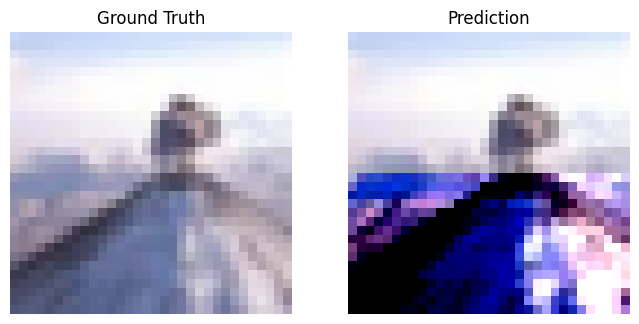